In [1]:
!git clone --depth 1 https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
!bash Mecab-ko-for-Google-Colab/install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 17 (delta 1), reused 13 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (17/17), 1.53 MiB | 36.35 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Installing konlpy.....
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 36.8 MB/s eta 0:00:00
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2025-05-21 14:00:08--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 13.200.41.135, 13.200.41.134, 13.200.41.136, ...
Connecting to bitbucket.org (bitbucket.org)|13.200.41.135|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https:

In [2]:
!pip install mecab-python3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.8/588.8 kB 32.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import nltk
from sklearn.model_selection import train_test_split
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from konlpy.tag import Mecab
from tqdm.notebook import tqdm
import random
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

#1.baseline

In [ ]:
df = pd.read_csv("ChatbotData.csv")

In [ ]:
mecab = Mecab()

In [ ]:
def preprocess(sentence):
    sentence = re.sub(r"[^a-z0-9가-힣\.!\?\s]", "", sentence)
    return mecab.morphs(sentence)

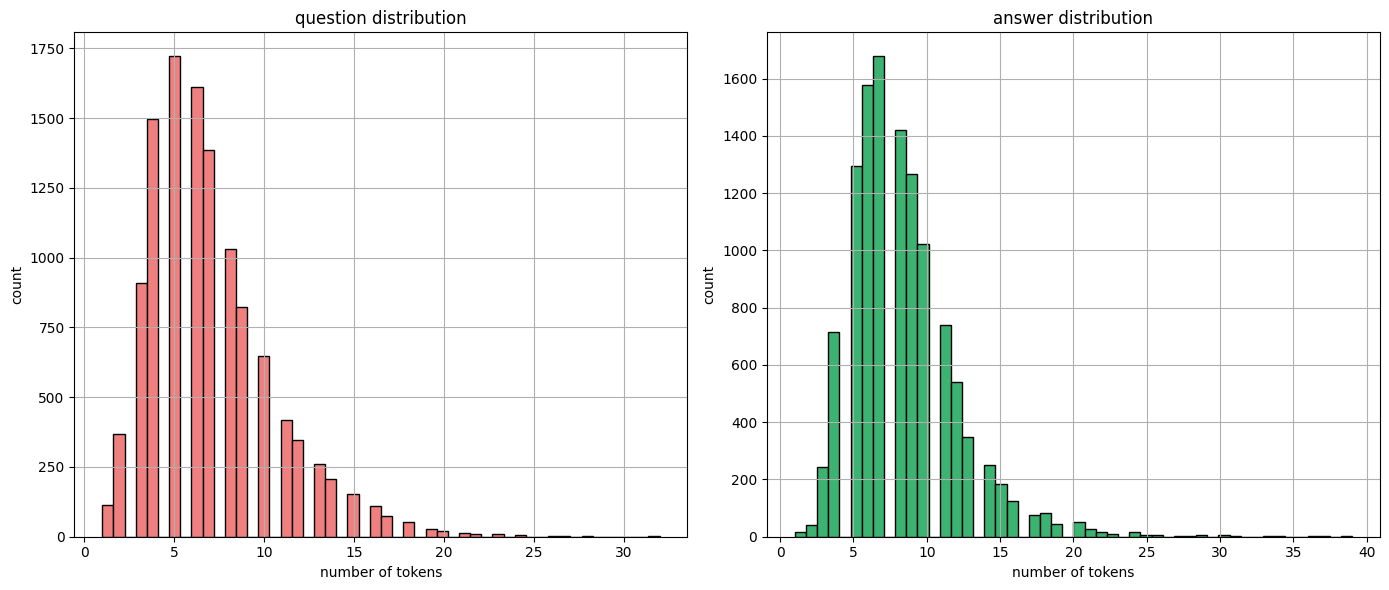

In [ ]:
df["Q_"] = df["Q"].apply(preprocess)
df["A_"] = df["A"].apply(preprocess)
token_leng1 = df["Q_"].apply(lambda x: len(x))
token_leng2 = df["A_"].apply(lambda x: len(x))

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(token_leng1, bins=50, color="lightcoral", edgecolor="black")
plt.title("question distribution")
plt.xlabel("number of tokens")
plt.ylabel("count")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(token_leng2, bins=50, color="mediumseagreen", edgecolor="black")
plt.title("answer distribution")
plt.xlabel("number of tokens")
plt.ylabel("count")
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
def build_corpus(df):
    df.dropna(inplace=True)
    df["Q_"] = df["Q"].apply(preprocess)
    df["A_"] = df["A"].apply(preprocess)
    df.drop_duplicates(subset=["Q_"], inplace=True)
    df.drop_duplicates(subset=["A_"], inplace=True)
    df.reset_index(drop=True, inplace=True)

    que_corpus, ans_corpus = [], []
    for i in range(len(df)):
        if len(df["Q_"][i]) < 28 and len(df["A_"][i]) < 35:
            que_corpus.append(df["Q_"][i])
            ans_corpus.append(["<SOS>"] + df["A_"][i] + ["<EOS>"])
    return que_corpus, ans_corpus

In [ ]:
que_corpus, ans_corpus = build_corpus(df)

In [ ]:
def compute_vocab_coverage(corpus, topk_list=[1000, 2000, 5000, 8000, 10000, 20000]):
    tokenizer = Tokenizer(filters="", oov_token=None)
    tokenizer.fit_on_texts(corpus)

    word_counts = tokenizer.word_counts  # collections.OrderedDict
    sorted_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

    total_tokens = sum([count for _, count in sorted_counts])

    print(f"총 토큰 수: {total_tokens}")
    print(f"전체 단어 수 (고유): {len(sorted_counts)}")

    cumulative = np.cumsum([count for _, count in sorted_counts])
    coverage_list = [
        cumulative[k - 1] / total_tokens * 100 if k <= len(cumulative) else 100.0
        for k in topk_list
    ]

    for k, cov in zip(topk_list, coverage_list):
        print(f"Vocab Size = {k:5d} → Coverage: {cov:.2f}%")

    plt.figure(figsize=(8, 4))
    plt.plot(np.arange(1, len(cumulative) + 1), cumulative / total_tokens * 100)
    plt.xlabel("Vocab Size (Top-N Words)")
    plt.ylabel("Coverage (%)")
    plt.title("Vocab Size vs. Token Coverage")
    plt.grid(True)
    plt.axhline(95, color="r", linestyle="--", label="95% Cutoff")
    plt.legend()
    plt.tight_layout()
    plt.show()

총 토큰 수: 57254
전체 단어 수 (고유): 4563
Vocab Size =  1000 → Coverage: 89.86%
Vocab Size =  2000 → Coverage: 94.95%
Vocab Size =  5000 → Coverage: 100.00%
Vocab Size =  8000 → Coverage: 100.00%
Vocab Size = 10000 → Coverage: 100.00%
Vocab Size = 20000 → Coverage: 100.00%


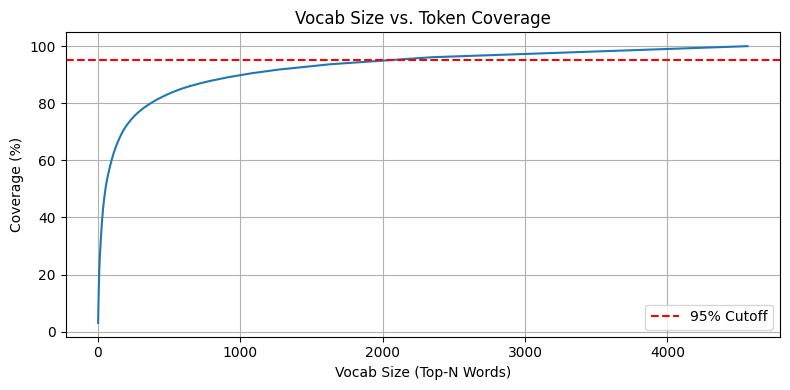

In [9]:
compute_vocab_coverage(que_corpus)

In [ ]:
def tokenize(corpus1, corpus2, vocab_size=None, oov_token="<OOV>"):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, filters="")
    tokenizer.fit_on_texts(corpus1 + corpus2)

    tensor1 = tokenizer.texts_to_sequences(corpus1)
    tensor2 = tokenizer.texts_to_sequences(corpus2)

    tensor1 = tf.keras.preprocessing.sequence.pad_sequences(tensor1, padding="post")
    tensor2 = tf.keras.preprocessing.sequence.pad_sequences(tensor2, padding="post")

    return tensor1, tensor2, tokenizer

In [ ]:
enc_corpus, dec_corpus, tokenizer = tokenize(que_corpus, ans_corpus)

In [ ]:
enc_train, enc_test, dec_train, dec_test = train_test_split(
    enc_corpus, dec_corpus, test_size=0.1, shuffle=True, random_state=42
)

BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
train_dataset = (
    train_dataset.shuffle(len(enc_train)).batch(BATCH_SIZE).prefetch(AUTOTUNE)
)

valid_dataset = tf.data.Dataset.from_tensor_slices((enc_test, dec_test))
valid_dataset = valid_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [ ]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2 * (i // 2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table


def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]


def generate_lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask


def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)

    dec_lookahead_mask = generate_lookahead_mask(tgt.shape[1])
    dec_tgt_padding_mask = generate_padding_mask(tgt)
    dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask)

    return enc_mask, dec_enc_mask, dec_mask


# Multi Head Attention 구현
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None:
            scaled_qk += mask * -1e9

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions

    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x

    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask
        )

        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights


class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation="relu")
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)

        return out


class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):
        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, enc_attn


class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        # Q, K, V 순서에 주의하세요!
        out, dec_enc_attn = self.enc_dec_attn(
            Q=out, K=enc_out, V=enc_out, mask=dec_enc_mask
        )
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn


class Encoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [
            EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)
        ]

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):
        out = x

        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)

        return out, enc_attns


class Decoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [
            DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)
        ]

    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x

        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = self.dec_layers[i](
                out, enc_out, dec_enc_mask, padding_mask
            )

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns


class Transformer(tf.keras.Model):
    def __init__(
        self,
        n_layers,
        d_model,
        n_heads,
        d_ff,
        src_vocab_size,
        tgt_vocab_size,
        pos_len,
        dropout=0.2,
        shared_fc=True,
        shared_emb=False,
    ):
        super(Transformer, self).__init__()

        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = tf.keras.layers.Embedding(
                src_vocab_size, d_model
            )
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc:
            out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        dec_out, dec_attns, dec_enc_attns = self.decoder(
            dec_in, enc_out, dec_enc_mask, dec_mask
        )

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

In [ ]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()

        self.d_model = d_model
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = step**-0.5
        arg2 = step * (self.warmup_steps**-1.5)

        return (self.d_model**-0.5) * tf.math.minimum(arg1, arg2)

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

In [ ]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[
        :, 1:
    ]  # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(
            src, tgt_in, enc_mask, dec_enc_mask, dec_mask
        )
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [ ]:
@tf.function
def eval_step(src, tgt, model):
    tgt_in = tgt[:, :-1]
    gold = tgt[:, 1:]

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    predictions, enc_attns, dec_attns, dec_enc_attns = model(
        src, tgt_in, enc_mask, dec_enc_mask, dec_mask
    )

    loss = loss_function(gold, predictions)

    return loss, enc_attns, dec_attns, dec_enc_attns

In [ ]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best = None
        self.wait = 0
        self.stopped_epoch = 0
        self.stop_training = False

    def on_epoch_end(self, epoch, current):
        if self.best is None or current < self.best - self.min_delta:
            self.best = current
            self.wait = 0
            return True
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stop_training = True
                self.stopped_epoch = epoch
            return False

In [ ]:
def plot_loss_graph(train_log, test_log):
    epochs = range(1, len(train_log) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_log, label="Train Loss")
    plt.plot(epochs, test_log, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train/Test Loss per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def main(
    transformer,
    optimizer,
    name,
    EPOCHS=10,
    early_stopping=EarlyStopping(patience=3, min_delta=0.001),
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    save=True,
):
    train_log = []
    valid_log = []

    for epoch in range(EPOCHS):
        total_loss = 0

        dataset_count = tf.data.experimental.cardinality(train_dataset).numpy()
        tqdm_bar = tqdm(total=dataset_count)

        for batch, (src, tgt) in enumerate(train_dataset):
            loss, _, _, _ = train_step(src, tgt, transformer, optimizer)
            total_loss += loss

            tqdm_bar.set_description(f"Epoch {epoch + 1}")
            tqdm_bar.set_postfix(loss=total_loss.numpy() / (batch + 1))
            tqdm_bar.update(1)

        tqdm_bar.close()
        train_epoch_loss = total_loss.numpy() / dataset_count
        train_log.append(train_epoch_loss)
        print(f"Epoch {epoch + 1} Train Loss: {train_epoch_loss:.4f}")

        val_loss_total = 0
        val_batches = tf.data.experimental.cardinality(valid_dataset).numpy()

        for batch, (src, tgt) in enumerate(valid_dataset):
            loss, _, _, _ = eval_step(src, tgt, transformer)
            val_loss_total += loss

        val_epoch_loss = val_loss_total.numpy() / val_batches
        valid_log.append(val_epoch_loss)
        print(f"Epoch {epoch + 1} Validation Loss: {val_epoch_loss:.4f}")

        is_best = early_stopping.on_epoch_end(epoch, val_epoch_loss)
        if save:
            if is_best:
                transformer.save_weights(name + "best_model.weights.h5")
                print(f"Best model saved at epoch {epoch+1}")

        if early_stopping.stop_training:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
    plot_loss_graph(train_log, valid_log)

    if save:
        transformer.load_weights(name + "best_model.weights.h5")

    return transformer, train_log, valid_log

---

In [ ]:
import tensorflow.keras.backend as K

K.clear_session()

In [ ]:
transformer1 = Transformer(
    n_layers=1,
    d_model=512,
    n_heads=8,
    d_ff=1024,
    src_vocab_size=len(tokenizer.word_index) + 1,
    tgt_vocab_size=len(tokenizer.word_index) + 1,
    pos_len=80,
    dropout=0.2,
    shared_fc=True,
    shared_emb=True,
)

d_model = 512

In [ ]:
learning_rate = LearningRateScheduler(d_model, warmup_steps=1000)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
)

early_stopping = EarlyStopping(patience=4, min_delta=0.001)

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 5.8102
Epoch 1 Validation Loss: 4.4342
Best model saved at epoch 1


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 3.8721
Epoch 2 Validation Loss: 3.7600
Best model saved at epoch 2


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.1167
Epoch 3 Validation Loss: 3.5802
Best model saved at epoch 3


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 2.3861
Epoch 4 Validation Loss: 3.6830


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 1.5980
Epoch 5 Validation Loss: 4.0870


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 1.0709
Epoch 6 Validation Loss: 4.5330


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 0.9277
Epoch 7 Validation Loss: 4.7435
Early stopping triggered at epoch 7


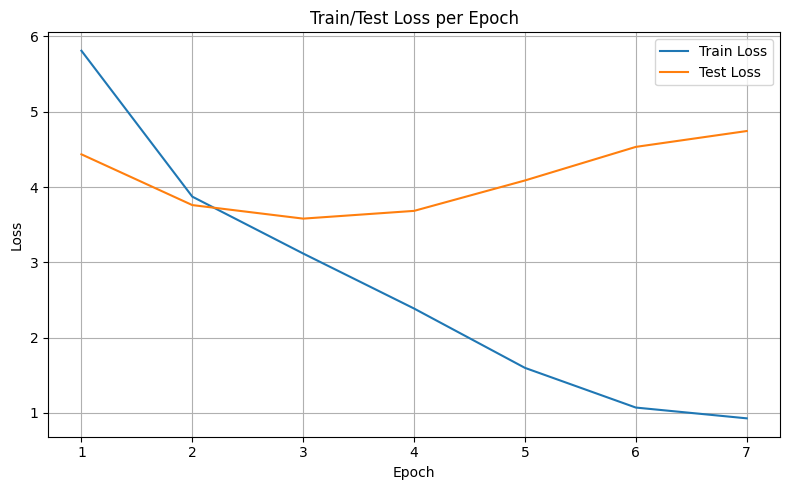

In [ ]:
transformer1, train_log, valid_log = main(
    transformer1,
    optimizer,
    "transformer1_",
    EPOCHS=10,
    early_stopping=early_stopping,
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
)

#2.hyperparam

In [39]:
tf.config.run_functions_eagerly(True)

In [ ]:
transformer_args = {
    "n_layers": 1,
    "d_model": 512,
    "n_heads": 8,
    "d_ff": 1024,
    "src_vocab_size": len(len(tokenizer.word_index)) + 1,
    "tgt_vocab_size": len(len(tokenizer.word_index)) + 1,
    "pos_len": 80,
    "dropout": 0.2,
    "shared_fc": True,
    "shared_emb": True,
}

# Hyperparameters
# > n_layers: 1
# > d_model: 368
# > n_heads: 8
# > d_ff: 1024
# > dropout: 0.2

# Training Parameters
# > Warmup Steps: 1000
# > Batch Size: 64
# > Epoch At: 10

In [ ]:
def tuner(transformer_args, name, warmup_steps=1000, epoch=10):
    transformer = Transformer(**transformer_args)
    d_model = transformer_args["d_model"]

    learning_rate = LearningRateScheduler(d_model, warmup_steps=1000)
    optimizer = tf.keras.optimizers.Adam(
        learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
    )
    early_stopping = EarlyStopping(patience=3, min_delta=0.001)

    transformer, train_log, valid_log = main(
        transformer,
        optimizer,
        name,
        EPOCHS=epoch,
        early_stopping=early_stopping,
        train_dataset=train_dataset,
        valid_dataset=valid_dataset,
        save=False,
    )
    return early_stopping.best

In [ ]:
from itertools import product

search_space = {
    "n_layers": [1, 2, 3],
    "d_model": [128, 256, 368, 512, 1024],
    "n_heads": [4, 8],
    "d_ff": [512, 1024, 2048],
    "dropout": [0.1, 0.2, 0.3],
}

In [51]:
keys, values = zip(*search_space.items())
arg_combinations = [dict(zip(keys, v)) for v in product(*values)]

In [62]:
result.sort(key=lambda x: x[6])
print("Best config:", result[0])
print("Second best config:", result[1])
print("Third best config:", result[2])

Best config: (1, 128, 8, 2048, 0.2, 100, np.float64(3.6044225692749023))
Second best config: (1, 256, 4, 512, 0.3, 500, np.float64(3.6078077952067056))
Third best config: (1, 128, 8, 2048, 0.2, 500, np.float64(3.6096461613972983))


In [63]:
result

[(1, 128, 8, 2048, 0.2, 100, np.float64(3.6044225692749023)),
 (1, 256, 4, 512, 0.3, 500, np.float64(3.6078077952067056)),
 (1, 128, 8, 2048, 0.2, 500, np.float64(3.6096461613972983)),
 (1, 128, 8, 2048, 0.3, 100, np.float64(3.6120290756225586)),
 (1, 256, 4, 512, 0.2, 300, np.float64(3.612045923868815)),
 (1, 128, 4, 2048, 0.3, 1000, np.float64(3.612820307413737)),
 (1, 128, 8, 512, 0.2, 2000, np.float64(3.6129252115885415)),
 (1, 128, 4, 512, 0.2, 2000, np.float64(3.6133365631103516)),
 (1, 128, 4, 2048, 0.1, 1000, np.float64(3.6141316095987954)),
 (1, 128, 4, 2048, 0.3, 100, np.float64(3.6161410013834634)),
 (1, 128, 8, 1024, 0.3, 1000, np.float64(3.6164331436157227)),
 (1, 128, 8, 2048, 0.2, 1000, np.float64(3.617093086242676)),
 (1, 256, 4, 512, 0.2, 2000, np.float64(3.6178099314371743)),
 (1, 128, 8, 2048, 0.3, 300, np.float64(3.618189811706543)),
 (1, 128, 8, 2048, 0.3, 2000, np.float64(3.6185220082600913)),
 (1, 256, 4, 512, 0.1, 500, np.float64(3.619053522745768)),
 (1, 128, 4

In [ ]:
search_space = {
    "n_layers": [1],
    "d_model": [128, 368],
    "n_heads": [8],
    "d_ff": [512, 2048],
    "dropout": [0.2],
}

In [67]:
keys, values = zip(*search_space.items())
arg_combinations = [dict(zip(keys, v)) for v in product(*values)]

Trial 1/4: {'n_layers': 1, 'd_model': 128, 'n_heads': 8, 'd_ff': 512, 'dropout': 0.2}
Warmup Steps: 500


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.3496
Epoch 1 Validation Loss: 4.8788


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.3105
Epoch 2 Validation Loss: 4.0015


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.6049
Epoch 3 Validation Loss: 3.7331


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1980
Epoch 4 Validation Loss: 3.6520


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.8074
Epoch 5 Validation Loss: 3.7035


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3871
Epoch 6 Validation Loss: 3.8839


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9929
Epoch 7 Validation Loss: 4.1065
Early stopping triggered at epoch 7


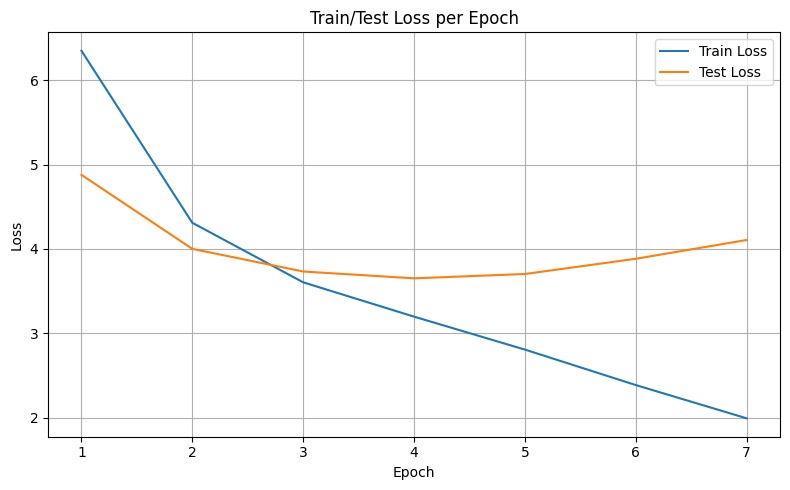

Trial 2/4: {'n_layers': 1, 'd_model': 128, 'n_heads': 8, 'd_ff': 2048, 'dropout': 0.2}
Warmup Steps: 500


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2046
Epoch 1 Validation Loss: 4.8186


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2193
Epoch 2 Validation Loss: 3.9172


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5207
Epoch 3 Validation Loss: 3.6602


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1337
Epoch 4 Validation Loss: 3.6220


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7624
Epoch 5 Validation Loss: 3.6784


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3691
Epoch 6 Validation Loss: 3.8399


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9834
Epoch 7 Validation Loss: 4.1002
Early stopping triggered at epoch 7


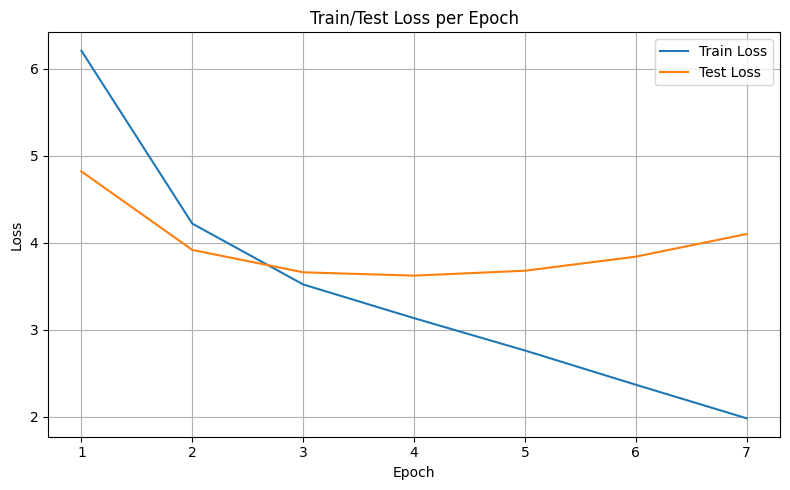

Trial 3/4: {'n_layers': 1, 'd_model': 368, 'n_heads': 8, 'd_ff': 512, 'dropout': 0.2}
Warmup Steps: 500


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 5.9933
Epoch 1 Validation Loss: 4.5416


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 3.9847
Epoch 2 Validation Loss: 3.8225


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.3007
Epoch 3 Validation Loss: 3.6228


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 2.7174
Epoch 4 Validation Loss: 3.6466


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.0513
Epoch 5 Validation Loss: 3.9184


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 1.4427
Epoch 6 Validation Loss: 4.3032
Early stopping triggered at epoch 6


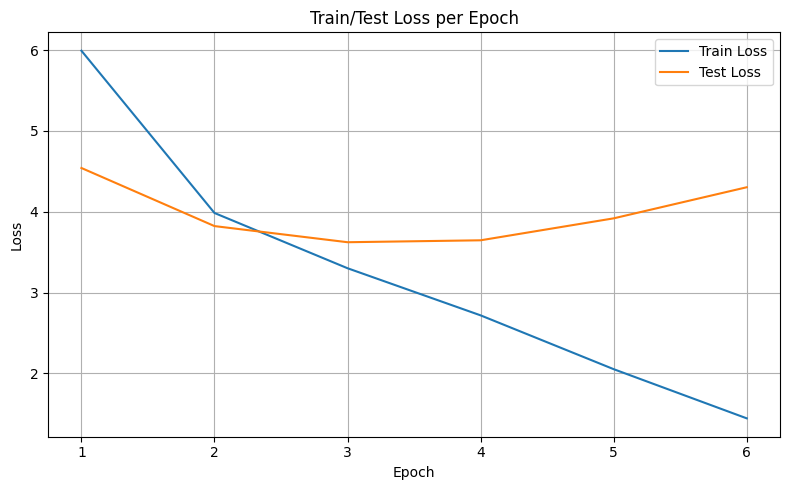

Trial 4/4: {'n_layers': 1, 'd_model': 368, 'n_heads': 8, 'd_ff': 2048, 'dropout': 0.2}
Warmup Steps: 500


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 5.8953
Epoch 1 Validation Loss: 4.4985


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 3.9179
Epoch 2 Validation Loss: 3.7784


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.2281
Epoch 3 Validation Loss: 3.6069


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 2.6253
Epoch 4 Validation Loss: 3.6832


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 1.9355
Epoch 5 Validation Loss: 3.9153


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 1.3440
Epoch 6 Validation Loss: 4.3660
Early stopping triggered at epoch 6


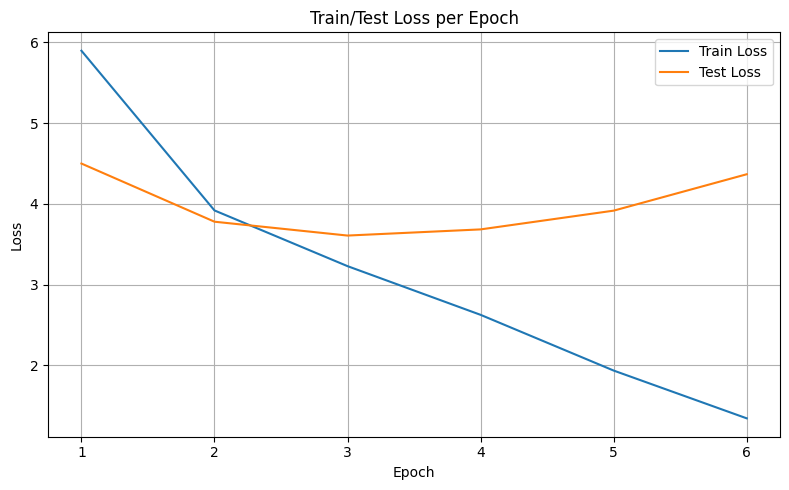

In [ ]:
result = []
hp_order = ["n_layers", "d_model", "n_heads", "d_ff", "dropout"]
for i, hp_args in enumerate(arg_combinations):
    print(f"Trial {i+1}/{len(arg_combinations)}: {hp_args}")

    full_args = {
        "src_vocab_size": len(tokenizer.word_index) + 1,
        "tgt_vocab_size": len(tokenizer.word_index) + 1,
        "pos_len": 80,
        "shared_fc": True,
        "shared_emb": True,
        **hp_args,
    }

    for warm in [500]:
        print(f"Warmup Steps: {warm}")
        best_val_loss = tuner(
            full_args, f"transformer_{i+1}_", warmup_steps=warm, epoch=20
        )
        hp_tuple = tuple(hp_args[k] for k in hp_order) + (warm, best_val_loss)
        result.append(hp_tuple)
        K.clear_session()

In [69]:
result.sort(key=lambda x: x[6])
print("Best config:", result[0])
print("Second best config:", result[1])
print("Third best config:", result[2])

Best config: (1, 368, 8, 2048, 0.2, 500, np.float64(3.606917063395182))
Second best config: (1, 128, 8, 2048, 0.2, 500, np.float64(3.6220099131266275))
Third best config: (1, 368, 8, 512, 0.2, 500, np.float64(3.6227506001790366))


In [70]:
result

[(1, 368, 8, 2048, 0.2, 500, np.float64(3.606917063395182)),
 (1, 128, 8, 2048, 0.2, 500, np.float64(3.6220099131266275)),
 (1, 368, 8, 512, 0.2, 500, np.float64(3.6227506001790366)),
 (1, 128, 8, 512, 0.2, 500, np.float64(3.6520207722981772))]

Trial 1/4: {'n_layers': 1, 'd_model': 128, 'n_heads': 8, 'd_ff': 1024, 'dropout': 0.2}
Warmup Steps: 500


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.3095
Epoch 1 Validation Loss: 4.8128


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2418
Epoch 2 Validation Loss: 3.9932


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5818
Epoch 3 Validation Loss: 3.6947


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1817
Epoch 4 Validation Loss: 3.6306


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7897
Epoch 5 Validation Loss: 3.6986


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3742
Epoch 6 Validation Loss: 3.8514


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9645
Epoch 7 Validation Loss: 4.1025
Early stopping triggered at epoch 7


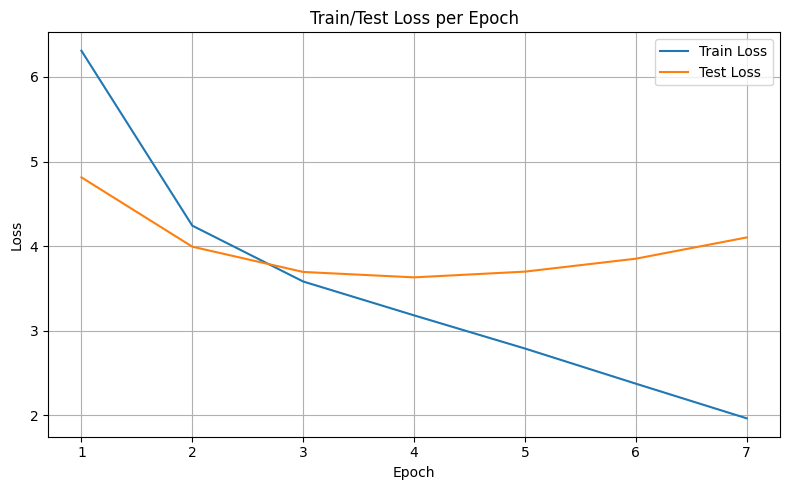

Trial 2/4: {'n_layers': 1, 'd_model': 368, 'n_heads': 8, 'd_ff': 1024, 'dropout': 0.2}
Warmup Steps: 500


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 5.9737
Epoch 1 Validation Loss: 4.5438


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 3.9690
Epoch 2 Validation Loss: 3.8069


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.2654
Epoch 3 Validation Loss: 3.5962


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 2.6745
Epoch 4 Validation Loss: 3.6615


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.0022
Epoch 5 Validation Loss: 3.9189


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 1.4006
Epoch 6 Validation Loss: 4.2821
Early stopping triggered at epoch 6


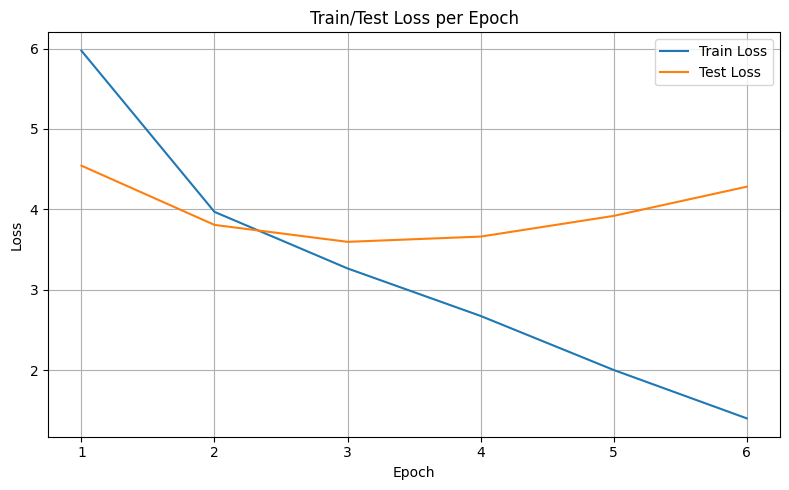

Trial 3/4: {'n_layers': 2, 'd_model': 128, 'n_heads': 8, 'd_ff': 1024, 'dropout': 0.2}
Warmup Steps: 500


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.0909
Epoch 1 Validation Loss: 4.8050


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2212
Epoch 2 Validation Loss: 3.9698


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5429
Epoch 3 Validation Loss: 3.6985


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1176
Epoch 4 Validation Loss: 3.6704


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7073
Epoch 5 Validation Loss: 3.7739


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.2864
Epoch 6 Validation Loss: 3.9701


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9118
Epoch 7 Validation Loss: 4.2153
Early stopping triggered at epoch 7


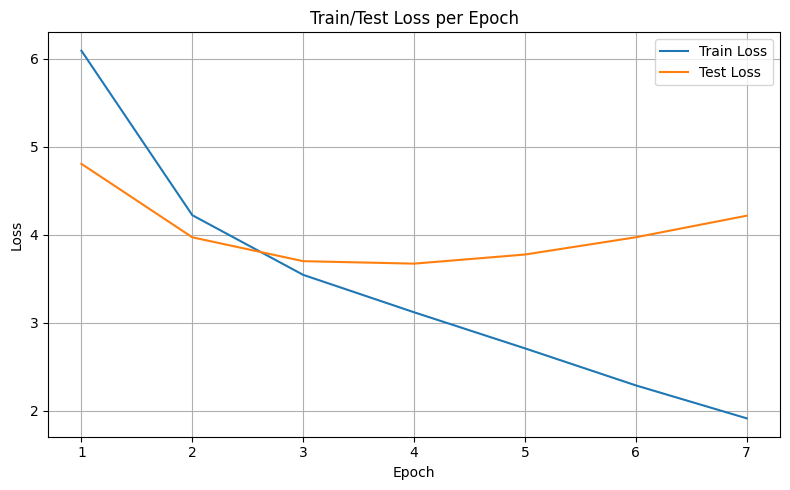

Trial 4/4: {'n_layers': 2, 'd_model': 368, 'n_heads': 8, 'd_ff': 1024, 'dropout': 0.2}
Warmup Steps: 500


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 5.8685
Epoch 1 Validation Loss: 4.5587


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 3.9704
Epoch 2 Validation Loss: 3.8753


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.2069
Epoch 3 Validation Loss: 3.6959


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 2.4991
Epoch 4 Validation Loss: 3.8810


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 1.8004
Epoch 5 Validation Loss: 4.1680


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 1.3265
Epoch 6 Validation Loss: 4.5122
Early stopping triggered at epoch 6


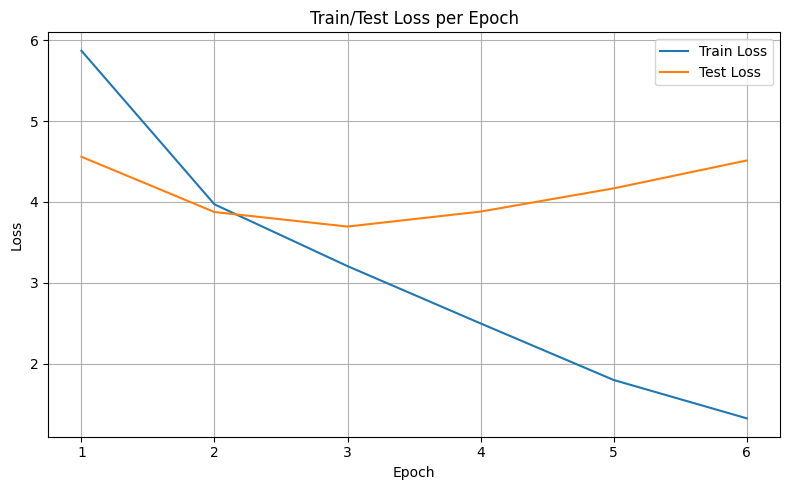

Best config: (1, 368, 8, 1024, 0.2, 500, np.float64(3.596155802408854))
Second best config: (1, 128, 8, 1024, 0.2, 500, np.float64(3.630647659301758))
Third best config: (2, 128, 8, 1024, 0.2, 500, np.float64(3.670385996500651))


IndexError: list index out of range

In [ ]:
search_space = {
    "n_layers": [1, 2],
    "d_model": [128, 368],
    "n_heads": [8],
    "d_ff": [1024],
    "dropout": [0.2],
}

keys, values = zip(*search_space.items())
arg_combinations = [dict(zip(keys, v)) for v in product(*values)]

result = []
hp_order = ["n_layers", "d_model", "n_heads", "d_ff", "dropout"]
for i, hp_args in enumerate(arg_combinations):
    print(f"Trial {i+1}/{len(arg_combinations)}: {hp_args}")

    full_args = {
        "src_vocab_size": len(tokenizer.word_index) + 1,
        "tgt_vocab_size": len(tokenizer.word_index) + 1,
        "pos_len": 80,
        "shared_fc": True,
        "shared_emb": True,
        **hp_args,
    }

    for warm in [500]:
        print(f"Warmup Steps: {warm}")
        best_val_loss = tuner(
            full_args, f"transformer_{i+1}_", warmup_steps=warm, epoch=20
        )
        hp_tuple = tuple(hp_args[k] for k in hp_order) + (warm, best_val_loss)
        result.append(hp_tuple)
        K.clear_session()

result.sort(key=lambda x: x[6])
print("Best config:", result[0])
print("Second best config:", result[1])
print("Third best config:", result[2])